In [95]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btc-data/btc_data.pkl


In [96]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression,Ridge,ElasticNet,SGDRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import scipy as sp
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR,LinearSVR
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate

In [97]:
data = pd.read_pickle("/kaggle/input/btc-data/btc_data.pkl")

In [98]:
data.head()

,machine_time_stamp,exchange_time_stamp,open_interst,last_price,bid_prices1,bid_prices2,bid_prices3,bid_prices4,bid_prices5,bid_size1,...,ask_prices4,ask_prices5,limit_up_price,limit_down_price,turnover,volume,type,source,instrument_id,instrument_digital_id
0,1592582400058816512,1592553600052999936,0.0,0.0,9377.3,9377.2,9377.1,9376.9,9376.7,527,...,9378.4,9378.5,0.0,0.0,0.0,0,0,0,_BUSWAP,0
1,1592582400161379072,1592553600156000000,0.0,0.0,9377.3,9377.2,9377.1,9376.9,9376.7,591,...,9378.4,9378.5,0.0,0.0,0.0,0,0,0,_BUSWAP,0
2,1592582400264047360,1592553600257999872,0.0,0.0,9377.3,9377.2,9377.1,9376.9,9376.7,594,...,9378.4,9379.1,0.0,0.0,0.0,0,0,0,_BUSWAP,0
3,1592582400365902080,1592553600360000000,0.0,0.0,9377.3,9377.2,9377.1,9376.9,9376.7,604,...,9378.4,9379.1,0.0,0.0,0.0,0,0,0,_BUSWAP,0
4,1592582400469083392,1592553600463000064,0.0,0.0,9377.3,9377.2,9377.1,9376.9,9376.7,614,...,9379.1,9379.2,0.0,0.0,0.0,0,0,0,_BUSWAP,0


In [99]:
#dropping redundant columns
cols_to_del = ['limit_up_price','limit_down_price','source','volume','instrument_id',"instrument_digital_id",'turnover','type',"open_interst","last_price"]
data.drop(columns=cols_to_del,axis=1,inplace=True)

Feature Enginnering
1. Spread
2. Volume Order Imbalance
3. Mid Price Change

In [100]:
#find spread
data['spread'] = data['ask_prices1'] - data['bid_prices1']
#find mid
data['mid'] = (data['bid_prices1'] + data['ask_prices1'])/2
data['mid_change'] = data.mid.diff()
data['return'] = data['spread']/data['mid']
data['Volume_Order_Imbalance'] = data['bid_size1']/(data['bid_size1'] + data['ask_size1'])
data['BA_size_spread'] = data['ask_size1'] - data['bid_size1']

Resample per second

In [101]:
#converting machine timestamp and exchange time stamp to pandas timestamp
data.machine_time_stamp = pd.to_datetime(data.machine_time_stamp, unit='ns')
data.exchange_time_stamp = pd.to_datetime(data.exchange_time_stamp, unit='ns')

In [102]:
df = data.resample("1s",on="machine_time_stamp")[['bid_prices1','ask_prices1','bid_size1','ask_size1','spread','mid','return','Volume_Order_Imbalance','BA_size_spread']].mean()
mid_change_df = data.resample("1s",on="machine_time_stamp")['mid_change'].sum()
df = df.merge(mid_change_df,left_index=True,right_index=True)
# get return in 10s
df['return_10s'] = df['return'].shift(10)

In [103]:
# dropping nan rows
df.dropna(inplace=True)

Plotting Distribution of Target and Features

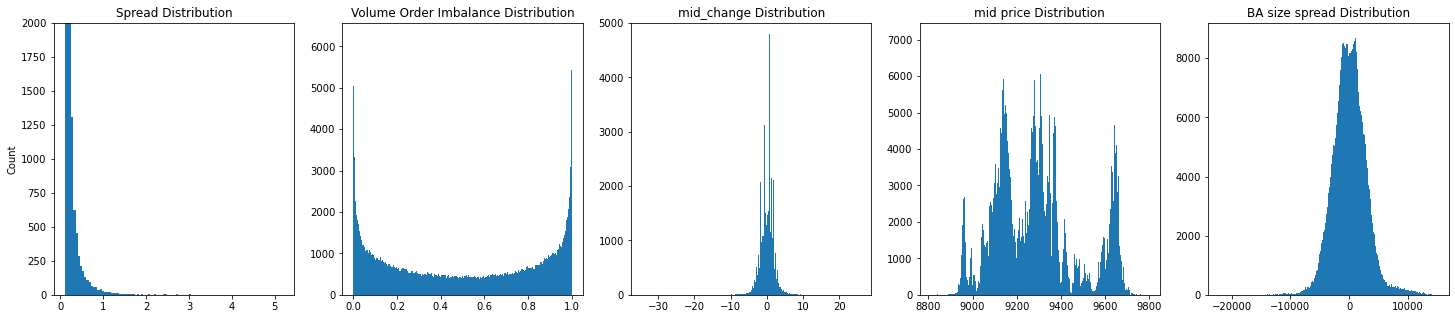

In [104]:
f, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(25,5))
n, bins, patches=ax1.hist(df["spread"],bins=100)
n, bins, patches=ax2.hist(df["Volume_Order_Imbalance"],bins=1000)
n, bins, patches=ax3.hist(df["mid_change"],bins=500)
n, bins, patches=ax4.hist(df["mid"],bins=500)
n, bins, patches=ax5.hist(df["BA_size_spread"],bins=500)
ax1.set_ylim(0,2000)
ax1.set_title('Spread Distribution')
ax1.set_ylabel('Count')
ax2.set_title('Volume Order Imbalance Distribution')
ax3.set_ylim(0,5000)
ax3.set_title('mid_change Distribution')
ax4.set_title('mid price Distribution')
ax5.set_title('BA size spread Distribution')
plt.show()

Feature Scaling using Min-Max Scaler

In [105]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled,columns=df.columns)
df_scaled.index=df.index

In [106]:
df_scaled

,bid_prices1,ask_prices1,bid_size1,ask_size1,spread,mid,return,Volume_Order_Imbalance,BA_size_spread,mid_change,return_10s
machine_time_stamp,,,,,,,,,,,
2020-06-19 16:00:10,0.573664,0.573230,0.046500,0.020818,3.566661e-13,0.573447,0.000775,0.784363,0.569890,0.572139,0.000775
2020-06-19 16:00:18,0.573664,0.573230,0.069800,0.008097,3.566661e-13,0.573447,0.000775,0.938334,0.547966,0.572139,0.000775
2020-06-19 16:00:19,0.573664,0.573230,0.060619,0.021993,3.566661e-13,0.573447,0.000775,0.831386,0.560203,0.572139,0.000775
2020-06-19 16:00:20,0.573664,0.573230,0.062587,0.009159,3.566661e-13,0.573447,0.000775,0.923789,0.553587,0.572139,0.000775
2020-06-19 16:00:21,0.573664,0.573230,0.062260,0.008097,3.566661e-13,0.573447,0.000775,0.931376,0.553393,0.572139,0.000775
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 11:59:53,0.343823,0.343183,0.003978,0.282007,3.566661e-13,0.343503,0.001247,0.024599,0.706312,0.572139,0.001247
2020-06-30 11:59:56,0.343823,0.343183,0.003624,0.282206,3.566661e-13,0.343503,0.001247,0.022454,0.706648,0.572139,0.001247
2020-06-30 11:59:57,0.343823,0.343183,0.003656,0.282026,3.566661e-13,0.343503,0.001247,0.022660,0.706552,0.572139,0.001247


Split train dev test

In [107]:
#split train test data
#train_size = int(len(df)*0.8)
#test_size = len(df) - train_size
#train_df = df[0:train_size]
#test_df = df[train_size:]
train,dev_test = train_test_split(df_scaled,test_size=0.4,random_state=20)
dev,test = train_test_split(dev_test,test_size=0.5,random_state=2)

In [108]:
train.corr().return_10s

bid_prices1              -0.071670
ask_prices1              -0.071626
bid_size1                -0.012687
ask_size1                -0.013597
spread                    0.216686
mid                      -0.071648
return                    0.218884
Volume_Order_Imbalance    0.001523
BA_size_spread           -0.001788
mid_change                0.017342
return_10s                1.000000
Name: return_10s, dtype: float64

In [109]:
dev.corr().return_10s

bid_prices1              -0.066497
ask_prices1              -0.066449
bid_size1                -0.012208
ask_size1                -0.014327
spread                    0.241113
mid                      -0.066473
return                    0.244932
Volume_Order_Imbalance    0.002742
BA_size_spread           -0.002607
mid_change                0.008277
return_10s                1.000000
Name: return_10s, dtype: float64

In [110]:
test.corr().return_10s

bid_prices1              -0.068285
ask_prices1              -0.068253
bid_size1                -0.010096
ask_size1                -0.009900
spread                    0.158491
mid                      -0.068269
return                    0.161850
Volume_Order_Imbalance    0.002669
BA_size_spread           -0.000875
mid_change                0.005646
return_10s                1.000000
Name: return_10s, dtype: float64

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


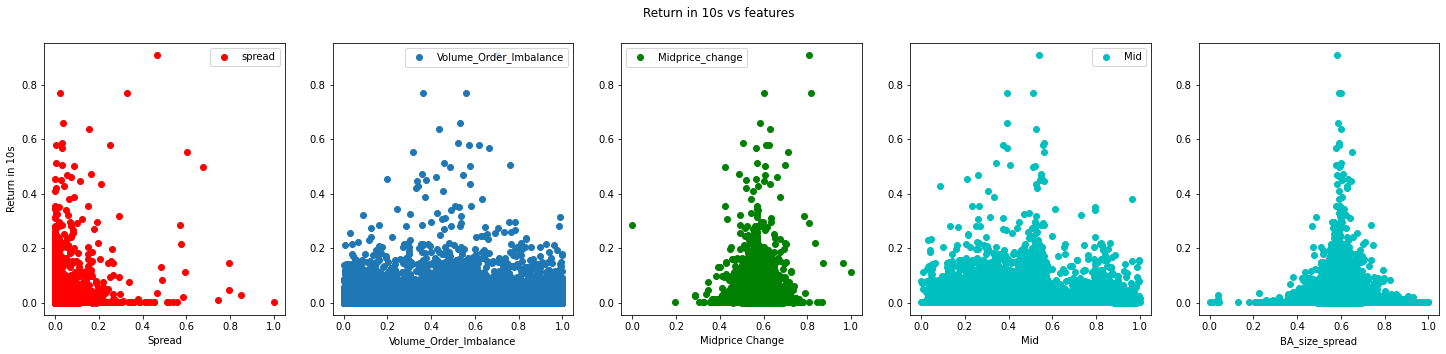

In [111]:
f, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(25,5))
ax1.scatter(x=train.spread,y=train.return_10s,c='r',label="spread")
ax2.scatter(x=train['Volume_Order_Imbalance'],y=train.return_10s,label="Volume_Order_Imbalance")
ax3.scatter(x=train['mid_change'],y=train.return_10s,label="Midprice_change",c="green")
ax4.scatter(x=train['mid'],y=train.return_10s,label="Mid",c="c")
ax5.scatter(x=train['BA_size_spread'],y=train.return_10s,label="Mid",c="c")
ax1.set_ylabel('Return in 10s')
ax1.set_xlabel('Spread')
ax2.set_xlabel('Volume_Order_Imbalance')
ax3.set_xlabel('Midprice Change')
ax4.set_xlabel('Mid')
ax5.set_xlabel("BA_size_spread")
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
f.suptitle("Return in 10s vs features")
plt.show()

Feature Selection

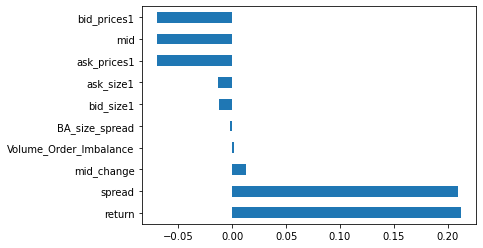

In [112]:
#Feature Selection with correlation
df_corr_health = df.corr()['return_10s'].sort_values(ascending=False)[1:]
top_corr_features = df_corr_health.index
# plot top 20 most correlated features to our target (HEALTH)
df_corr_health.plot(kind='barh')
plt.show()

In [113]:
"""
#Feature Selection with Tree Based Regressor
rf_model = RandomForestRegressor()
rf_model.fit(train.drop('return_10s',axis=1),train.return_10s)
"""

"\n#Feature Selection with Tree Based Regressor\nrf_model = RandomForestRegressor()\nrf_model.fit(train.drop('return_10s',axis=1),train.return_10s)\n"

In [114]:
"""
feat_importances = pd.Series(rf_model.feature_importances_, index=train.drop('return_10s',axis=1).columns)
feat_importances
"""

"\nfeat_importances = pd.Series(rf_model.feature_importances_, index=train.drop('return_10s',axis=1).columns)\nfeat_importances\n"

In [115]:
train.corr()

,bid_prices1,ask_prices1,bid_size1,ask_size1,spread,mid,return,Volume_Order_Imbalance,BA_size_spread,mid_change,return_10s
bid_prices1,1.000000,1.000000,-0.110566,-0.125447,-0.017583,1.000000,-0.070816,0.005025,-0.020175,0.000669,-0.071670
ask_prices1,1.000000,1.000000,-0.110575,-0.125455,-0.017378,1.000000,-0.070611,0.005025,-0.020175,0.000663,-0.071626
bid_size1,-0.110566,-0.110575,1.000000,-0.321001,-0.041498,-0.110571,-0.035494,0.725138,-0.779763,0.095771,-0.012687
ask_size1,-0.125447,-0.125455,-0.321001,1.000000,-0.038854,-0.125451,-0.032141,-0.680441,0.843247,-0.082576,-0.013597
spread,-0.017583,-0.017378,-0.041498,-0.038854,1.000000,-0.017481,0.998361,-0.000663,-0.002132,-0.027787,0.216686
mid,1.000000,1.000000,-0.110571,-0.125451,-0.017481,1.000000,-0.070713,0.005025,-0.020175,0.000666,-0.071648
return,-0.070816,-0.070611,-0.035494,-0.032141,0.998361,-0.070713,1.000000,-0.000910,-0.001102,-0.027569,0.218884
Volume_Order_Imbalance,0.005025,0.005025,0.725138,-0.680441,-0.000663,0.005025,-0.000910,1.000000,-0.861372,0.157190,0.001523
BA_size_spread,-0.020175,-0.020175,-0.779763,0.843247,-0.002132,-0.020175,-0.001102,-0.861372,1.000000,-0.108944,-0.001788
mid_change,0.000669,0.000663,0.095771,-0.082576,-0.027787,0.000666,-0.027569,0.157190,-0.108944,1.000000,0.017342


In [116]:
# bid_size1, ask_size1, BA_size_spread are highly correlated with Volume_Order_Imbalance
# Thus only pick Volume_Order_Imbalance to prevent overfitting
feature_cols = ['spread','Volume_Order_Imbalance','mid_change','mid']
target_col = "return_10s"

Modelling

In [117]:
train_y = train[target_col].to_numpy()
dev_y = dev[target_col].to_numpy()
test_y = test[target_col].to_numpy()
train_X = train[feature_cols]
dev_X = dev[feature_cols]
test_X = test[feature_cols]

Building Baseline Model with Linear Regression

Using Pearson correlation coefficient, KS test p value, MSE as a performance metric, R2

In [118]:
baseline = LinearRegression().fit(train_X,train_y)
baseline_dev_result = baseline.predict(dev_X)

--------------------Train Result----------------------
Pearson correlation coefficient of baseline model :  0.22827333284398013
KS Test p-value :  0.0
R2 Score :  0.05210871448769849
Mean Squared Error of baseline model :  5.280246454425575e-05
******************************************************
--------------------Dev Result----------------------
Pearson correlation coefficient of baseline model :  0.24826805910992703
KS Test p-value :  0.0
R2 Score :  0.060924189177634425
Mean Squared Error of baseline model :  5.3725481055418724e-05


Text(0.5, 1.0, 'Baseline Result and Ground Truth DEV')

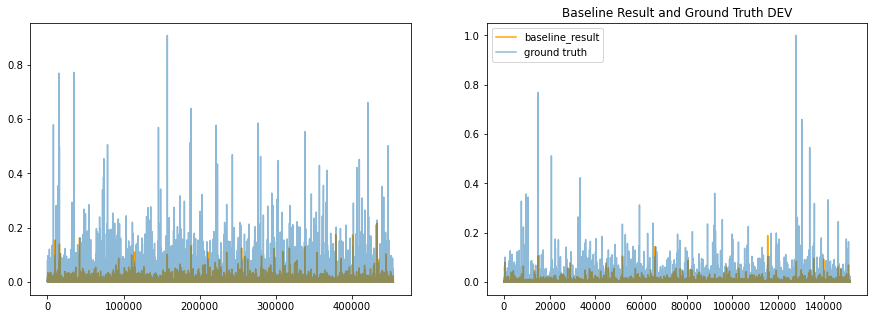

In [119]:
train_pred = baseline.predict(train_X)
res_corr,p = sp.stats.pearsonr(train_y,train_pred)
print("--------------------Train Result----------------------")
print("Pearson correlation coefficient of baseline model : ",res_corr)
print("R2 Score : ",r2_score(train_y,train_pred))
# using MSE score as a metric
print("Mean Squared Error of baseline model : ",mean_squared_error(train_y,train_pred))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(train_pred,label='train_result',alpha=1,c='orange')
ax1.plot(train_y,label="ground truth",alpha=0.5)
plt.title('Baseline Result and Ground Truth TRAIN')
print("******************************************************")
res_corr,p = sp.stats.pearsonr(baseline_dev_result,dev_y)
print("--------------------Dev Result----------------------")
print("Pearson correlation coefficient of baseline model : ",res_corr)
print("R2 Score : ",r2_score(dev_y,baseline_dev_result))
# using MSE score as a metric
print("Mean Squared Error of baseline model : ",mean_squared_error(dev_y,baseline_dev_result))

plt.plot(baseline_dev_result,label='baseline_result',alpha=1,c='orange')
plt.plot(dev_y,label="ground truth",alpha=0.5)
plt.legend()
plt.title('Baseline Result and Ground Truth DEV')

Building Baseline Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(train_X,train_y)

In [ ]:
filename = 'baseline_rf.sav'
pickle.dump(rf_model, open(filename, 'wb'))

--------------------Train Result----------------------
Pearson correlation coefficient of rf model :  0.9627558482159537
KS Test p-value :  0.0
R2 Score :  0.860148196644798
Mean Squared Error of rf model :  7.79047133461324e-06
******************************************************
--------------------Dev Result----------------------
Pearson correlation coefficient of baseline RF Regressor (DEV) :  0.28845395785407624
KS Test p-value (DEV) :  0.0
R2 Score :  0.04926578534167103
Mean Squared Error of baseline RF Regressor (DEV) :  5.439247018154366e-05


Text(0.5, 1.0, 'Random Forest Result and Ground Truth DEV')

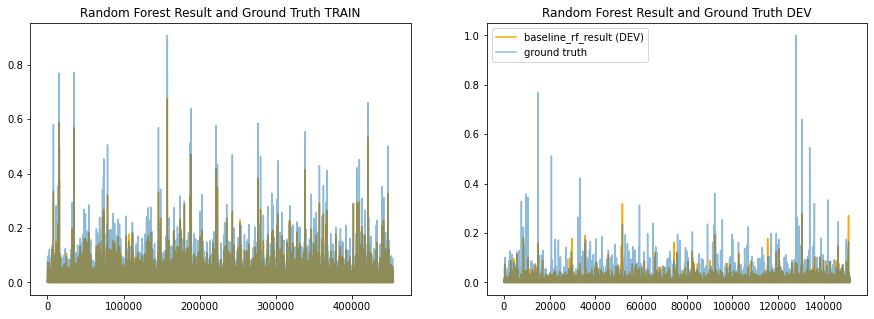

In [122]:
train_pred = rf_model.predict(train_X)
res_corr,p = sp.stats.pearsonr(train_y,train_pred)
print("--------------------Train Result----------------------")
print("Pearson correlation coefficient of rf model : ",res_corr)
print("R2 Score : ",r2_score(train_y,train_pred))
# using MSE score as a metric
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
print("Mean Squared Error of rf model : ",mean_squared_error(train_y,train_pred))
ax1.plot(train_pred,label='train_result',alpha=1,c='orange')
ax1.plot(train_y,label="ground truth",alpha=0.5)
ax1.set_title('Random Forest Result and Ground Truth TRAIN')
#use Pearson correlation coefficien as a metric
print("******************************************************")
print("--------------------Dev Result----------------------")
res_corr,p = sp.stats.pearsonr(rf_model.predict(dev_X),dev_y)
print("Pearson correlation coefficient of baseline RF Regressor (DEV) : ",res_corr)
print("R2 Score : ",r2_score(dev_y,rf_model.predict(dev_X)))
# using MSE score as a metric
print("Mean Squared Error of baseline RF Regressor (DEV) : ",mean_squared_error(dev_y,rf_model.predict(dev_X)))

ax2.plot(rf_model.predict(dev_X),label='baseline_rf_result (DEV)',alpha=1,c='orange')
ax2.plot(dev_y,label="ground truth",alpha=0.5)
ax2.legend()
ax2.set_title('Random Forest Result and Ground Truth DEV')

Other Regressors such as Elastic Net, LinearSVR underoperform compare to baseline so these models are not under consideration

Building XGB Regressor

In [123]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(train_X,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

--------------------Train Result----------------------
Pearson correlation coefficient of rf model :  0.7047738602007049
KS Test p-value :  0.0
R2 Score :  0.48008822138752916
Mean Squared Error of rf model :  2.896178462226158e-05
*****************************************************
--------------------Dev Result----------------------
Pearson correlation coefficient of baseline xgb (DEV):  0.35965135483991717
KS Test p-value (DEV):  0.0
R2 Score :  0.12464379681098159
Mean Squared Error of baseline xgb (DEV):  5.0080017575993986e-05


Text(0.5, 1.0, 'XGB Result and Ground Truth DEV')

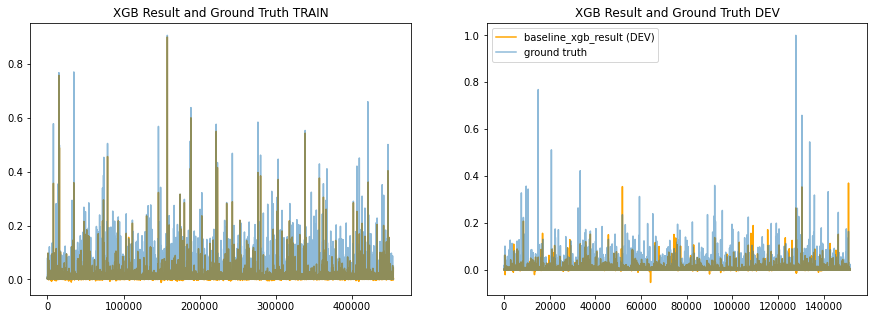

In [124]:
train_pred = xgb_model.predict(train_X)
res_corr,p = sp.stats.pearsonr(train_y,train_pred)
print("--------------------Train Result----------------------")
print("Pearson correlation coefficient of rf model : ",res_corr)
print("R2 Score : ",r2_score(train_y,train_pred))
# using MSE score as a metric
print("Mean Squared Error of rf model : ",mean_squared_error(train_y,train_pred))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(train_pred,label='train_result',alpha=1,c='orange')
ax1.plot(train_y,label="ground truth",alpha=0.5)
ax1.set_title('XGB Result and Ground Truth TRAIN')
xgb_corr,p = sp.stats.pearsonr(xgb_model.predict(dev_X),dev_y)
print("*****************************************************")
print("--------------------Dev Result----------------------")
print("Pearson correlation coefficient of baseline xgb (DEV): ",xgb_corr)
print("R2 Score : ",r2_score(dev_y,xgb_model.predict(dev_X)))
# using MSE score as a metric
print("Mean Squared Error of baseline xgb (DEV): ",mean_squared_error(xgb_model.predict(dev_X),dev_y))
ax2.plot(xgb_model.predict(dev_X),label='baseline_xgb_result (DEV)',alpha=1,c='orange')
ax2.plot(dev_y,label="ground truth",alpha=0.5)
ax2.legend()
ax2.set_title('XGB Result and Ground Truth DEV')

In [125]:
lgbm = LGBMRegressor()
lgbm.fit(train_X,train_y)

LGBMRegressor()

--------------------Train Result----------------------
Pearson correlation coefficient of rf model :  0.5149022267022894
KS Test p-value :  0.0
R2 Score :  0.24829954848090285
Mean Squared Error of rf model :  4.187361678062717e-05
*****************************************************
--------------------Dev Result----------------------
Pearson correlation coefficient of baseline LGBM (DEV):  0.32555480481599824
KS Test p-value (DEV):  0.0
R2 Score :  0.10542071857747337
Mean Squared Error of baseline lgbm (DEV):  5.117978940863949e-05


Text(0.5, 1.0, 'LGBM Result and Ground Truth DEV')

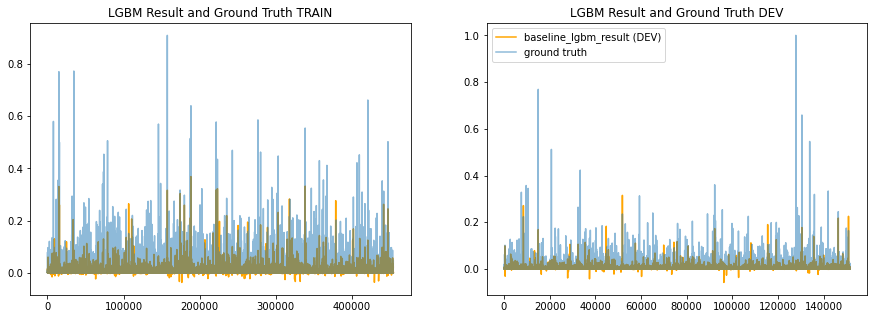

In [126]:
train_pred = lgbm.predict(train_X)
res_corr,p = sp.stats.pearsonr(train_y,train_pred)
print("--------------------Train Result----------------------")
print("Pearson correlation coefficient of rf model : ",res_corr)
print("R2 Score : ",r2_score(train_y,train_pred))
# using MSE score as a metric
print("Mean Squared Error of rf model : ",mean_squared_error(train_y,train_pred))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(train_pred,label='train_result',alpha=1,c='orange')
ax1.plot(train_y,label="ground truth",alpha=0.5)
ax1.set_title('LGBM Result and Ground Truth TRAIN')
lgbm_corr,p = sp.stats.pearsonr(lgbm.predict(dev_X),dev_y)
print("*****************************************************")
print("--------------------Dev Result----------------------")
print("Pearson correlation coefficient of baseline LGBM (DEV): ",lgbm_corr)
print("R2 Score : ",r2_score(dev_y,lgbm.predict(dev_X)))
# using MSE score as a metric
print("Mean Squared Error of baseline lgbm (DEV): ",mean_squared_error(lgbm.predict(dev_X),dev_y))
ax2.plot(lgbm.predict(dev_X),label='baseline_lgbm_result (DEV)',alpha=1,c='orange')
ax2.plot(dev_y,label="ground truth",alpha=0.5)
ax2.legend()
ax2.set_title('LGBM Result and Ground Truth DEV')

Out of all these models, XGBOOST and LIGHTGMB outperform others but LIGHTGBM is quicker to train show less degrees of overfitting and higher ability to generalise. Thus I decide to go ahead with LIGHTGBM

Hyperparameter Tuning

As LIGHGBM are quick to train, I am going to use random search CV to tune hyperparameter

In [127]:
df_cv = pd.concat([train,dev])

In [128]:
cv_X = df_cv[feature_cols].to_numpy()
cv_y = df_cv[target_col].to_numpy()

In [129]:
regres = LGBMRegressor()

In [130]:
scores = cross_validate(regres, cv_X, cv_y, cv=4,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

In [131]:
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error'])

In [132]:
print(scores['test_neg_mean_squared_error'].mean()*-1)
print(scores['test_r2'].mean())

5.160303856676981e-05
0.07909393961522668


In [150]:
params = {} #initialize parameters
params['learning_rate'] = np.linspace(0.1, 0.3,3)
params['boosting_type'] = ['gbdt', 'dart', 'goss']
params['num_leaves'] = np.linspace(40,80,5,dtype=int)
params['max_depth'] = [3,4,5]

In [151]:
params

{'learning_rate': array([0.1, 0.2, 0.3]),
 'boosting_type': ['gbdt', 'dart', 'goss'],
 'num_leaves': array([40, 50, 60, 70, 80]),
 'max_depth': [3, 4, 5]}

In [152]:
clf = RandomizedSearchCV(regres,params,n_iter=20,scoring='r2',return_train_score=True,cv=4,refit='r2',verbose=2)

In [ ]:
search = clf.fit(cv_X, cv_y)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] num_leaves=80, max_depth=3, learning_rate=0.2, boosting_type=goss 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  num_leaves=80, max_depth=3, learning_rate=0.2, boosting_type=goss, total=   2.3s
[CV] num_leaves=80, max_depth=3, learning_rate=0.2, boosting_type=goss 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  num_leaves=80, max_depth=3, learning_rate=0.2, boosting_type=goss, total=   2.3s
[CV] num_leaves=80, max_depth=3, learning_rate=0.2, boosting_type=goss 
[CV]  num_leaves=80, max_depth=3, learning_rate=0.2, boosting_type=goss, total=   2.3s
[CV] num_leaves=80, max_depth=3, learning_rate=0.2, boosting_type=goss 
[CV]  num_leaves=80, max_depth=3, learning_rate=0.2, boosting_type=goss, total=   2.3s
[CV] num_leaves=40, max_depth=4, learning_rate=0.3, boosting_type=goss 
[CV]  num_leaves=40, max_depth=4, learning_rate=0.3, boosting_type=goss, total=   2.5s
[CV] num_leaves=40, max_depth=4, learning_rate=0.3, boosting_type=goss 
[CV]  num_leaves=40, max_depth=4, learning_rate=0.3, boosting_type=goss, total=   2.6s
[CV] num_leaves=40, max_depth=4, learning_rate=0.3, boosting_type=goss 
[CV]  num_leaves=40, max_depth=4, learning_rate=0.3, boosting_type=goss, total=   2.5s
[CV] num_leaves=40, max_depth=4, learning_rate=0.3, boosting_type=goss 
[CV]  num_leaves=40, max_depth=4, learning_rat

In [137]:
search.best_params_

{'num_leaves': 60,
 'max_depth': 4,
 'learning_rate': 0.1,
 'boosting_type': 'dart'}

In [138]:
search.best_score_

0.09331194398935913

In [139]:
r2_score(test_y,search.predict(test_X))
res_corr,p = sp.stats.pearsonr(test_y,search.predict(test_X))

In [140]:
res_corr

0.2438455852039237